In [1]:
import os
import errno
import argparse

import numpy as np
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import backend as K

from deepcell import get_data
from deepcell import make_training_data
from deepcell import rate_scheduler
from deepcell.model_zoo import bn_feature_net_3D
from deepcell.model_zoo import bn_feature_net_61x61_3D
from deepcell.model_zoo import dilated_bn_feature_net_61x61_3D
from deepcell.training import train_model_movie
from deepcell.training import train_model_sample_movie

Using TensorFlow backend.


# Fully Convolutional Training

In [2]:
DATA_OUTPUT_MODE = 'conv'
PADDING = 'same'
RESIZE = False
RESHAPE_SIZE = 256
NUM_FRAMES = 15  # get first N frames from each training folder

WIN_X = 30
WIN_Y = 30
WIN_Z = 2

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/MouseBrain/generic'
CONV_DATA_FILE = 'MouseBrain_3d_{}'.format(DATA_OUTPUT_MODE)

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

ROW_AXIS = 3 if IS_CHANNELS_FIRST else 2
COL_AXIS = 4 if IS_CHANNELS_FIRST else 3
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 4

# create these directories if they do not exist
for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
        print('Created new directory:', os.path.join(d, PREFIX))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [3]:
# Create the training data
make_training_data(
    dimensionality=3,
    max_training_examples=None,
    direc_name=os.path.join(DATA_DIR, PREFIX),
    file_name_save=os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE),
    channel_names=[''],  # for iterating over stacks of images from a montage
    training_direcs=None,  # all training directories
    output_mode=DATA_OUTPUT_MODE,
    window_size_x=WIN_X,
    window_size_y=WIN_Y,
    window_size_z=WIN_Z,
    padding=PADDING,
    reshape_size=None if not RESIZE else RESHAPE_SIZE,
    num_frames=NUM_FRAMES,
    montage_mode=True,  # annotation folder has montaged sub-dirs
    annotation_name='',  # basically channel name but for annotated images
    raw_image_direc='stacked_raw_parts',
    annotation_direc='annotated/all_montages')

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE) + '.npz'):
    print('\nData saved to', os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')


Data saved to /data/npz_data/cells/MouseBrain/generic/MouseBrain_3d_conv.npz


In [4]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# Set up training parameters
n_epoch = 32
batch_size = 1
frames_per_batch = 5
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.95)

# save the size of the input data for batch_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    batch_shape = (batch_size, X.shape[CHANNEL_AXIS], frames_per_batch, size[0], size[1])
else:
    batch_shape = (batch_size, frames_per_batch, size[0], size[1], X.shape[CHANNEL_AXIS])

X.shape: (220, 15, 256, 256, 1)
y.shape: (220, 15, 256, 256, 1)


In [5]:
## First, create a foreground/background separation model

# Instantiate the model
conv_model = bn_feature_net_3D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    batch_shape=batch_shape,
    norm_method='whole_image')

# Train the model
train_model_movie(
    model=conv_model,
    dataset=CONV_DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    frames_per_batch=frames_per_batch,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=rate_scheduler(lr=0.01, decay=0.95),
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (198, 15, 256, 256, 1)
y_train shape: (198, 15, 256, 256, 1)
X_test shape: (22, 15, 256, 256, 1)
y_test shape: (22, 15, 256, 256, 1)
Output Shape: (1, 5, 256, 256, 2)
Number of Classes: 2
Using real-time data augmentation.
Epoch 1/32
593/594 [============================>.] - ETA: 0s - loss: 0.1827 - acc: 0.9151
Epoch 00001: val_loss improved from inf to 0.19712, saving model to /data/models/cells/MouseBrain/generic/2018-08-24_MouseBrain_3d_conv__0.h5
594/594 [==============================] - 230s 387ms/step - loss: 0.1827 - acc: 0.9151 - val_loss: 0.1971 - val_acc: 0.9475
Epoch 2/32
593/594 [============================>.] - ETA: 0s - loss: 0.1680 - acc: 0.9206
Epoch 00002: val_loss improved from 0.19712 to 0.18203, saving model to /data/models/cells/MouseBrain/generic/2018-08-24_MouseBrain_3d_conv__0.h5
594/594 [==============================] - 212s 357ms/step - loss: 0.1679 - acc: 0.9206 - val_loss: 0.1820 - val_acc: 0.9362
Epoch 3/32
593/594 [======================

593/594 [============================>.] - ETA: 0s - loss: 0.1491 - acc: 0.9252
Epoch 00030: val_loss did not improve
594/594 [==============================] - 212s 357ms/step - loss: 0.1494 - acc: 0.9252 - val_loss: 0.1729 - val_acc: 0.9376
Epoch 31/32
593/594 [============================>.] - ETA: 0s - loss: 0.1496 - acc: 0.9251
Epoch 00031: val_loss did not improve
594/594 [==============================] - 212s 357ms/step - loss: 0.1495 - acc: 0.9251 - val_loss: 0.1779 - val_acc: 0.9419
Epoch 32/32
593/594 [============================>.] - ETA: 0s - loss: 0.1497 - acc: 0.9253
Epoch 00032: val_loss did not improve
594/594 [==============================] - 212s 357ms/step - loss: 0.1496 - acc: 0.9253 - val_loss: 0.1835 - val_acc: 0.9437


In [6]:
# With the trained model, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE + '.npz')

train_dict, test_dict = get_data(
    training_data_file, mode=DATA_OUTPUT_MODE, seed=21)

# too many batches at once causes OOM
X_test, y_test = test_dict[0][:4], test_dict[1][:4]

# To predict on variable number of frames
# we need to re-instantiate model and load weights
conv_weights_file = '2018-08-24_MouseBrain_3d_conv__0.h5'
conv_weights_file = os.path.join(MODEL_DIR, PREFIX, conv_weights_file)

run_conv_model = bn_feature_net_3D(
    n_features=2,
    batch_shape=X_test.shape,
    norm_method='whole_image')
run_conv_model.load_weights(conv_weights_file)

test_images_conv = run_conv_model.predict(X_test)

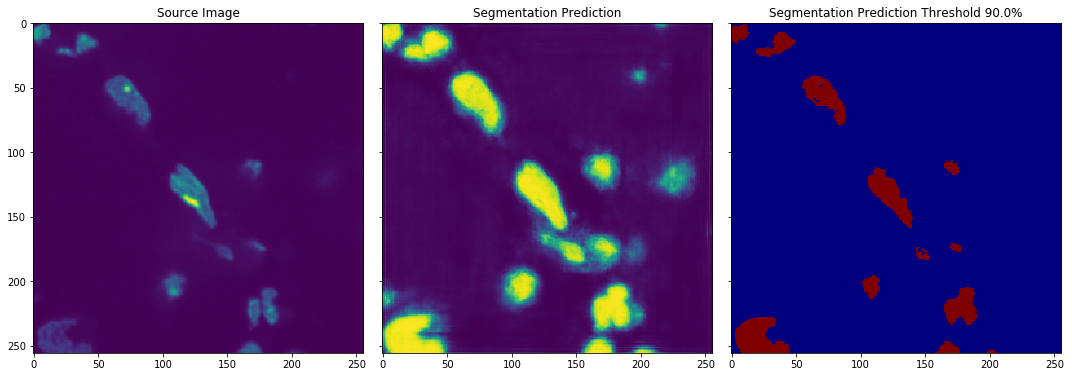

In [7]:
# Plot the results
import matplotlib.pyplot as plt
import matplotlib.animation as animation

index = 0
frame = 3

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, :, :, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_conv[index, frame, :, :, 1])
ax[1].set_title('Segmentation Prediction')

threshold = .9
ax[2].imshow(test_images_conv[index, frame, :, :, 1] > threshold, cmap='jet')
ax[2].set_title('Segmentation Prediction Threshold {}%'.format(threshold * 100))

fig.tight_layout()
plt.show()

# Sample Based Training

In [8]:
DATA_OUTPUT_MODE = 'sample'
PADDING = 'valid'
RESIZE = False
RESHAPE_SIZE = 256
NUM_FRAMES = 15

# Set sample window size
WIN_X = 30
WIN_Y = 30
WIN_Z = 2

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/MouseBrain/generic'

SAMPLE_DATA_FILE = 'MouseBrain_3d_{}'.format(DATA_OUTPUT_MODE)

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

ROW_AXIS = 3 if IS_CHANNELS_FIRST else 2
COL_AXIS = 4 if IS_CHANNELS_FIRST else 3
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 4

In [9]:
# Make the training data for foreground/background segmentation
make_training_data(
    dimensionality=3,
    direc_name=os.path.join(DATA_DIR, PREFIX),
    file_name_save=os.path.join(NPZ_DIR, PREFIX, SAMPLE_DATA_FILE),
    channel_names=[''],  # for iterating over stacks of images from a montage
    training_direcs=None,  # use all training directories
    output_mode=DATA_OUTPUT_MODE,
    max_training_examples=1e5,
    window_size_x=WIN_X,
    window_size_y=WIN_Y,
    window_size_z=WIN_Z,
    padding=PADDING,
    reshape_size=None if not RESIZE else RESHAPE_SIZE,
    num_frames=NUM_FRAMES,
    montage_mode=True,  # annotation folder has montaged sub-dirs
    annotation_name='',  # basically channel name but for annotated images
    raw_image_direc='stacked_raw_parts',
    annotation_direc='annotated/all_montages')

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, SAMPLE_DATA_FILE) + '.npz'):
    print('Data Saved to', os.path.join(NPZ_DIR, PREFIX, SAMPLE_DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')

Data Saved to /data/npz_data/cells/MouseBrain/generic/MouseBrain_3d_sample.npz


In [10]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, SAMPLE_DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# Set up training parameters
n_epoch = 32
batch_size = 128
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

X.shape: (220, 15, 256, 256, 1)
y.shape: (100000,)


In [11]:
# First, create a foreground/background separation model

# Instantiate the model
sample_model = bn_feature_net_61x61_3D(
    n_features=2,
    n_frames=2 * WIN_Z + 1,
    norm_method='whole_image',
    n_channels=X.shape[CHANNEL_AXIS])

# Train the model
train_model_sample_movie(
    model=sample_model,
    dataset=SAMPLE_DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (90000, 5, 61, 61, 1)
y_train shape: (90000,)
X_test shape: (10000, 5, 61, 61, 1)
y_test shape: (10000,)
Output Shape: (None, 2)
Number of Classes: 2
Using real-time data augmentation.
Epoch 1/32
702/703 [============================>.] - ETA: 0s - loss: 0.2327 - acc: 0.9061
Epoch 00001: val_loss improved from inf to 0.20001, saving model to /data/models/cells/MouseBrain/generic/2018-08-24_MouseBrain_3d_sample__0.h5
703/703 [==============================] - 181s 257ms/step - loss: 0.2326 - acc: 0.9062 - val_loss: 0.2000 - val_acc: 0.9319
Epoch 2/32
702/703 [============================>.] - ETA: 0s - loss: 0.2125 - acc: 0.9155
Epoch 00002: val_loss did not improve
703/703 [==============================] - 176s 250ms/step - loss: 0.2124 - acc: 0.9156 - val_loss: 0.2005 - val_acc: 0.9412
Epoch 3/32
702/703 [============================>.] - ETA: 0s - loss: 0.2079 - acc: 0.9182
Epoch 00003: val_loss did not improve
703/703 [==============================] - 176s 250ms/ste

Epoch 30/32
702/703 [============================>.] - ETA: 0s - loss: 0.1897 - acc: 0.9225
Epoch 00030: val_loss did not improve
703/703 [==============================] - 176s 250ms/step - loss: 0.1895 - acc: 0.9225 - val_loss: 0.1821 - val_acc: 0.9416
Epoch 31/32
702/703 [============================>.] - ETA: 0s - loss: 0.1871 - acc: 0.9229
Epoch 00031: val_loss did not improve
703/703 [==============================] - 176s 250ms/step - loss: 0.1870 - acc: 0.9229 - val_loss: 0.1946 - val_acc: 0.9276
Epoch 32/32
702/703 [============================>.] - ETA: 0s - loss: 0.1845 - acc: 0.9229
Epoch 00032: val_loss did not improve
703/703 [==============================] - 176s 250ms/step - loss: 0.1846 - acc: 0.9229 - val_loss: 0.1892 - val_acc: 0.9409


In [12]:
# With the trained model, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE + '.npz')

train_dict, test_dict = get_data(
    training_data_file, mode='conv', seed=21)

# too many batches at once causes OOM
X_test, y_test = test_dict[0][:4], test_dict[1][:4]

# To predict on variable number of frames
# we need to re-instantiate model and load weights
sample_weights_file = '2018-08-24_MouseBrain_3d_sample__0.h5'
sample_weights_file = os.path.join(MODEL_DIR, PREFIX, sample_weights_file)

run_sample_model = dilated_bn_feature_net_61x61_3D(
    n_features=2,
    n_frames=2 * WIN_Z + 1,
    input_shape=X_test.shape[1:],
    norm_method='whole_image')
run_sample_model.load_weights(sample_weights_file)

test_images_sample = run_sample_model.predict(X_test)

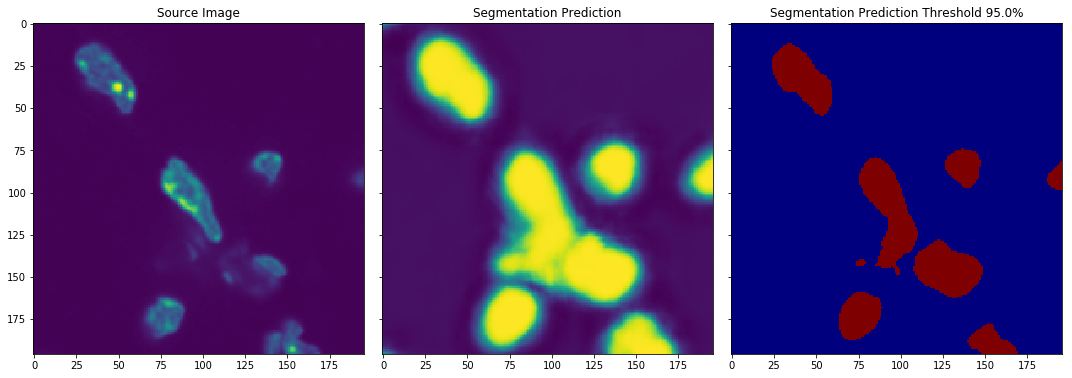

In [13]:
# Plot the results
import matplotlib.pyplot as plt
import matplotlib.animation as animation

index = 0
frame = 5

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, WIN_X:-WIN_X, WIN_Y:-WIN_Y, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_sample[index, frame, :, :, 1])
ax[1].set_title('Segmentation Prediction')

threshold = .95
ax[2].imshow(test_images_sample[index, frame, :, :, 1] > threshold, cmap='jet')
ax[2].set_title('Segmentation Prediction Threshold {}%'.format(threshold * 100))

fig.tight_layout()
plt.show()